In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import timm
import torch.nn as nn
import torch.nn.functional as F
import os
import datetime
import time

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import config

if config.ADSMI:
    from DL_finetune import ADSMI_DL_TVsplit as DL
    data_name = 'ADSMI'

#empty cuda cache
torch.cuda.empty_cache()

# Models

In [2]:
print(config.channels)

class ContrastiveTripletModelwithPH(nn.Module):
    def __init__(self, embedding_dim=2048, projection_dim=128):
        super(ContrastiveTripletModelwithPH, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        
        # Modifications for your dataset:
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove last FC layer to get embeddings
        self.encoder = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),  # 1st projection layer, can be modified
            nn.ReLU(),
            nn.Linear(embedding_dim, projection_dim)  # 2nd projection layer
        )
        
        # Dropout layer (with 50% probability, adjust as needed)
        #self.dropout = nn.Dropout(p=0.5)

    def forward_one(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten for easier downstream processing
        x = self.projection(x)  # Pass through the projection head
        #x = self.dropout(x)
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3
    
class ContrastiveTripletModel(nn.Module):
    def __init__(self):
        super(ContrastiveTripletModel, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        
        # Modifications for your dataset:
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove last FC layer to get embeddings
        self.encoder = nn.Sequential(*list(self.resnet50.children())[:-1])

    def forward_one(self, x):
        #print(f"Shape of x before unsqueeze: {x.shape}") # diagnostic print
        x = self.encoder(x)
        x = x.view(x.size(0), -1) # Flatten for easier downstream processing
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3

class ContrastiveTripletModelwithPHEfficient(nn.Module):
    def __init__(self, embedding_dim=1280, projection_dim=128, efficientnet_version='efficientnet_b0'):
        super(ContrastiveTripletModelwithPHEfficient, self).__init__()
        # Load a pre-trained EfficientNet. The last FC layer will be removed automatically.
        self.efficientnet = timm.create_model(efficientnet_version, pretrained=False, features_only=True)

        # Calculate the feature dimension of EfficientNet
        feature_dim = self.efficientnet.feature_info.channels()[-1]
        
        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(feature_dim, embedding_dim),  # 1st projection layer, can be modified
            nn.ReLU(),
            nn.Linear(embedding_dim, projection_dim)  # 2nd projection layer
        )
        # Dropout layer (if needed)
        #self.dropout = nn.Dropout(p=0.5)

    def forward_one(self, x):
        x = self.efficientnet(x)[-1]  # Get the last set of features
        x = F.adaptive_avg_pool2d(x, 1).view(x.size(0), -1)  # Global Average Pooling and Flatten
        x = self.projection(x)  # Pass through the projection head
        #x = self.dropout(x)
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3

3


# Set here the Model that should be fintuned

In [3]:
Pretrain_model_dir = "./results/FIRST-2023-11-08-21-epochs-100-ADSMI"


In [4]:


class FineTuneModel(nn.Module):
    def __init__(self, encoder, num_classes):
        super(FineTuneModel, self).__init__()
        self.encoder = encoder
        # Insert input size of the encoder here 2048
        # Adjust the classifier to match the ModifiedResnet50_Classifier structure
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


## Data


In [5]:
#------Datasplit
# Load the dataframe
labels_file = pd.read_csv('./data/labeled_ADSMI/labels_int.csv', index_col=0)
#train_df, test_df = train_test_split(labels_file, test_size=0.2, stratify=labels_file['Label_int'], random_state=47)
#val_df = test_df
randomstate = 47
train_df, temp = train_test_split(labels_file, test_size=0.2, stratify=labels_file['Label_int'], random_state=randomstate)
test_df, val_df = train_test_split(temp, test_size=0.5, stratify=temp['Label_int'], random_state=randomstate)
# train test split
print("Train size: ", len(train_df))
print("Test size: ", len(test_df))
print("Val size: ", len(val_df))



print(train_df["Label_int"].value_counts())
print(test_df["Label_int"].value_counts())
print(val_df["Label_int"].value_counts())

train_loader, test_loader = DL.create_generators_finetune_train(train_df,test_df)




Train size:  3776
Test size:  472
Val size:  472
Label_int
0    1760
2    1332
1     570
3     114
Name: count, dtype: int64
Label_int
0    220
2    166
1     72
3     14
Name: count, dtype: int64
Label_int
0    220
2    167
1     71
3     14
Name: count, dtype: int64


In [6]:
# Hyperparameters
num_epochs = config.finetune_epochs 
learning_rate = 0.00025
weight_decay = 0  # L2 regularization
batch_size = config.batch_size
patience = config.patience
 
#  Create an instance of the model
num_classes = len(set(labels_file["Label_int"]))  

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Early stopping parameters
patience = config.patience  # This value can be changed based on how many epochs of no improvement you're willing to wait
early_stop_counter = 0


# Load the entire pre-trained model (from your contrastive training)
pretrained_model = torch.load(Pretrain_model_dir + '/checkpoint.pth')
encoder_trained = pretrained_model.encoder

# Initialize the FineTuneModel with the pre-trained encoder
model = FineTuneModel(encoder_trained, num_classes).to(device)


# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-4 ) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay ) 

#Schedulers
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.6, verbose=True)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001, step_size_up=5, mode='triangular')
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=num_epochs)

#new folder path
finetune_results_dir = f'./finetune_results/FT_ADSMI_{num_epochs}_epochs_{datetime.datetime.now().strftime("%Y-%m-%d-%H")}'

# Create a new folder to save the results
if not os.path.exists(finetune_results_dir):
    os.makedirs(finetune_results_dir)

# create log file
with open(f'{finetune_results_dir}/log_file.txt', 'w') as log_file:
    log_file.write(f'########################################################\n')
    log_file.write(f'Finetuning on {data_name} dataset\n')
    log_file.write(f'Learning rate: {learning_rate}\n')
    log_file.write(f'Weight decay: {weight_decay}\n')
    log_file.write(f'Batch size: {batch_size}\n')
    log_file.write(f'Number of epochs: {num_epochs}\n')
    log_file.write(f'Patience: {patience}\n')
    log_file.write(f'Number of classes: {num_classes}\n')
    log_file.write(f'Train size: {len(train_df)}\n')
    log_file.write(f'Test size: {len(test_df)}\n')
    log_file.write(f'Val size: {len(val_df)}\n')
    log_file.write(f'freq_mask_param : {config.freq_mask_param}\n')
    log_file.write(f'time_mask_param : {config.time_mask_param}\n')
    log_file.write(f'########################################################\n\n')


train_losses = []
test_losses = []
best_accuracy = 0
best_loss = 1000
early_stop_counter = 0
#model_path = "./finetune_results/newgpulr0001_checkpoint.pth"

In [7]:

# Training loop

for epoch in range(num_epochs):
    model.train()
    for batch_idx, (spectrograms, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)
        train_losses.append(loss.item())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



    correct_predictions = 0
    total_samples = 0

    # Set the model to evaluation mode (important for dropout and batch normalization)
    model.eval()

    # Iterate through the test set
    with torch.no_grad():  # Disable gradient computation during testing
        for spectrograms, labels in test_loader:
            # Move data to the testing device
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())
            
            # Compute the predicted labels
            _, predicted = torch.max(outputs, 1)

            # Update evaluation metrics
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    #if new test accuracy is better than the previous best, save the model
    if correct_predictions / total_samples > best_accuracy:
        best_accuracy = correct_predictions / total_samples
        torch.save(model, finetune_results_dir + '/checkpoint.pth')
        early_stop_counter = 0
        #write to log file
        with open(finetune_results_dir + '/log_file.txt', 'a') as log_file:
            log_file.write(f"Best accuracy improved on epoch {epoch}: {best_accuracy * 100:.2f}%\n")
    
    #if new test loss is better than the previous best, save the model
    if test_losses[-1] < best_loss:
        best_loss = test_losses[-1]
        torch.save(model, finetune_results_dir + '/checkpoint_best_loss.pth')
        early_stop_counter = 0
        #write to log file
        with open(finetune_results_dir + '/log_file.txt', 'a') as log_file:
            log_file.write(f"Best loss improved on epoch {epoch}: {best_loss:.4f}\n")
        
    # Step the learning rate scheduler
    scheduler.step(test_losses[-1])

    # Calculate accuracy or other evaluation metrics
    accuracy = correct_predictions / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f} and Test Loss: {test_losses[-1]:.4f}")
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    early_stop_counter += 1
    # Write to log file
    with open(finetune_results_dir + '/log_file.txt', 'a') as log_file:
        log_file.write(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f} and Test Loss: {test_losses[-1]:.4f}, Accuracy:{accuracy}, early stopping count: {early_stop_counter} from {patience}\n")

    # Early stopping
    if early_stop_counter >= patience:
        print(f"Early stopping on epoch {epoch+1}")
        break



 51%|█████     | 60/118 [00:20<00:20,  2.89it/s]


KeyboardInterrupt: 

In [ ]:
# Save full model
torch.save(model, finetune_results_dir + '/Full_model_checkpoint.pth')


Evaluation Results:
Balanced Accuracy2: 90.35%
Test Accuracy: 89.41%

Evaluation Results:
Accuracy: 89.41%
Precision: 89.83%
Recall: 89.41%
F1-score: 89.45%
Kappa: 83.37%
                         precision    recall  f1-score   support

            [Kreischen]       0.88      0.91      0.90       220
[Kreischen][Quietschen]       0.82      0.92      0.87        71
              [Negativ]       0.96      0.86      0.91       167
           [Quietschen]       0.81      0.93      0.87        14

               accuracy                           0.89       472
              macro avg       0.87      0.90      0.88       472
           weighted avg       0.90      0.89      0.89       472



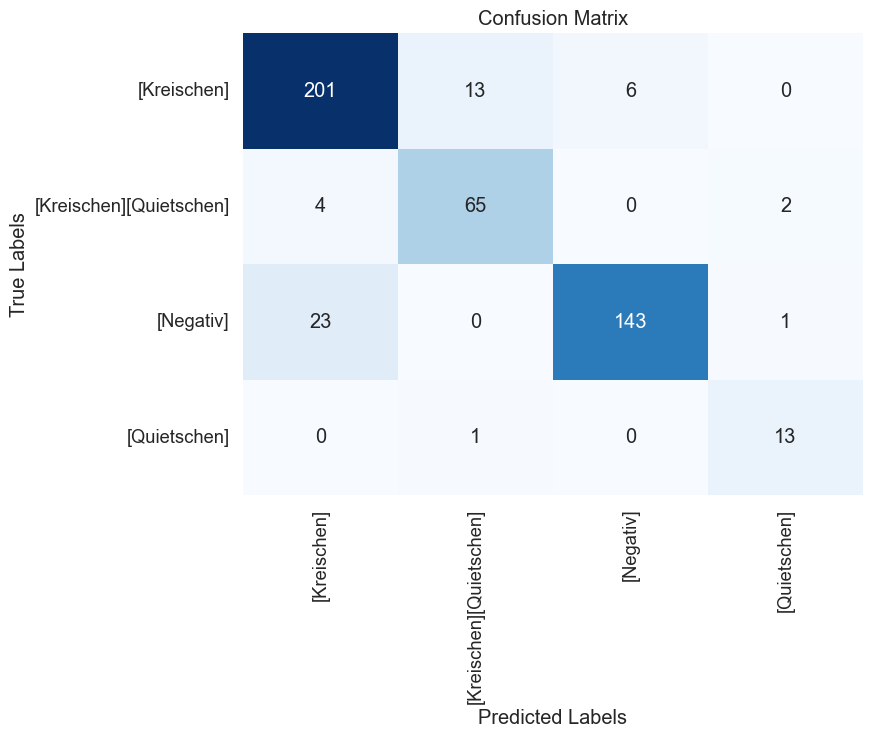

In [ ]:

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support,balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score



# Set the device for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#config.val_sound_length = 20

# Create a data loader for the test set
val_loader = DL.create_generators_finetune_val(val_df)  


model = torch.load(finetune_results_dir + '/Full_model_checkpoint.pth')
# Transfer the model to the testing device
model.to(device)

# Define a criterion for evaluation 
criterion = nn.CrossEntropyLoss()

# Initialize variables for evaluation metrics (e.g., accuracy)
correct_predictions = 0
total_samples = 0

# Define the label dictionary
true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# Set the model to evaluation mode 
model.eval()

# Initialize lists to store all true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Iterate through the test set
with torch.no_grad():
    for spectrograms, labels in val_loader:
        # Move data to the testing device
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        
        # Compute the predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels to the lists
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
accuracy = np.mean(all_true_labels == all_predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


#calculate balanced accuracy
balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
#kappa score
cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


print(f"\nEvaluation Results:")
#print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")
print(f"Kappa: {cohens_kappa * 100:.2f}%")

conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
def plot_confusion_matrix(conf_mat, class_labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    
    class_labels = [str(label) for label in class_labels]
    
    ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)

    return plt.gcf()  # Return the current figure

#create classification results text file
with open(f'{finetune_results_dir}/results_file_full.txt', 'w') as log_file:
    log_file.write(f"########################################################\n")
    log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
    log_file.write(f"Time Mask: {config.time_mask_param}\n")
    log_file.write(f"Random State:{randomstate} \n")
    log_file.write(f"Spectro:\n")
    log_file.write(f"        n_fft={2048},\n")
    log_file.write(f"        hop_length = {512},\n")
    log_file.write(f"        n_mels={128},  \n")
    log_file.write(f"        win_length = {2048},\n")
    log_file.write(f"Epochs: {num_epochs}\n")
    log_file.write(f"Batch size: {batch_size}\n")
    log_file.write(f"Optimizer: Adam\n")
    log_file.write(f"Learning rate: {learning_rate}\n")
    log_file.write(f"Weight decay: {weight_decay}\n")
    log_file.write(f"Scheduler: ReduceLROnPlateau\n")
    log_file.write(f"Model: ModifiedResnet50_Classifier \n")
    log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
    log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
    log_file.write(f"\nEvaluation Results:\n")
    log_file.write(f"Precision: {precision * 100:.2f}%\n")
    log_file.write(f"Recall: {recall * 100:.2f}%\n")
    log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
    log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Confusion Matrix:\n")
    log_file.write(f"{conf_mat}\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

#save this plot as a png file
print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
plot.savefig(f'{finetune_results_dir}/confusion_matrix_full.png')










Evaluation Results:
Balanced Accuracy2: 90.61%
Test Accuracy: 93.86%

Evaluation Results:
Accuracy: 93.86%
Precision: 93.97%
Recall: 93.86%
F1-score: 93.86%
Kappa: 90.34%
                         precision    recall  f1-score   support

            [Kreischen]       0.95      0.94      0.94       220
[Kreischen][Quietschen]       0.87      0.96      0.91        71
              [Negativ]       0.96      0.94      0.95       167
           [Quietschen]       0.92      0.79      0.85        14

               accuracy                           0.94       472
              macro avg       0.92      0.91      0.91       472
           weighted avg       0.94      0.94      0.94       472



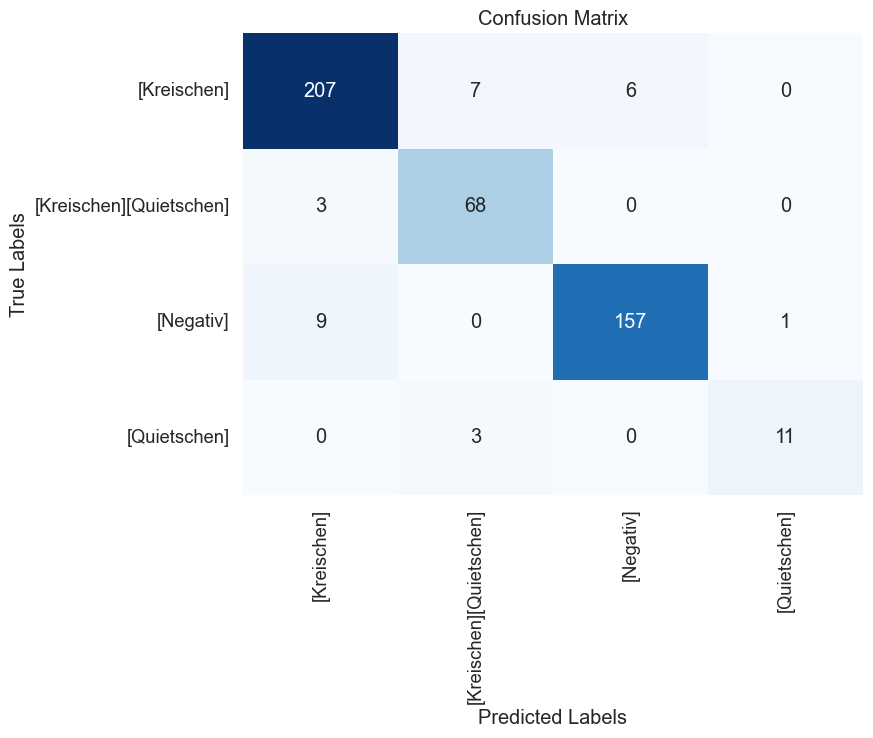

In [ ]:

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support,balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score



# Set the device for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#config.val_sound_length = 20

# Create a data loader for the test set
val_loader = DL.create_generators_finetune_val(val_df)  


model = torch.load(finetune_results_dir + '/checkpoint.pth')
#model = torch.load('./finetune_results/FT_ADSMI_120_epochs_2023-11-11-15/checkpoint.pth')
# Transfer the model to the testing device
model.to(device)

# Define a criterion for evaluation 
criterion = nn.CrossEntropyLoss()

# Initialize variables for evaluation metrics (e.g., accuracy)
correct_predictions = 0
total_samples = 0

# Define the label dictionary
true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# Set the model to evaluation mode 
model.eval()

# Initialize lists to store all true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Iterate through the test set
with torch.no_grad():
    for spectrograms, labels in val_loader:
        # Move data to the testing device
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        
        # Compute the predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels to the lists
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
accuracy = np.mean(all_true_labels == all_predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


#calculate balanced accuracy
balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
#kappa score
cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


print(f"\nEvaluation Results:")
#print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")
print(f"Kappa: {cohens_kappa * 100:.2f}%")

conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
def plot_confusion_matrix(conf_mat, class_labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    
    class_labels = [str(label) for label in class_labels]
    
    ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)

    return plt.gcf()  # Return the current figure

#create classification results text file
with open(f'{finetune_results_dir}/results_file_best.txt', 'w') as log_file:
    log_file.write(f"########################################################\n")
    log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
    log_file.write(f"Time Mask: {config.time_mask_param}\n")
    log_file.write(f"Random State:{randomstate} \n")
    log_file.write(f"Spectro:\n")
    log_file.write(f"        n_fft={2048},\n")
    log_file.write(f"        hop_length = {512},\n")
    log_file.write(f"        n_mels={128},  \n")
    log_file.write(f"        win_length = {2048},\n")
    log_file.write(f"Epochs: {num_epochs}\n")
    log_file.write(f"Batch size: {batch_size}\n")
    log_file.write(f"Optimizer: Adam\n")
    log_file.write(f"Learning rate: {learning_rate}\n")
    log_file.write(f"Weight decay: {weight_decay}\n")
    log_file.write(f"Scheduler: ReduceLROnPlateau\n")
    log_file.write(f"Model: ModifiedResnet50_Classifier \n")
    log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
    log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
    log_file.write(f"\nEvaluation Results:\n")
    log_file.write(f"Precision: {precision * 100:.2f}%\n")
    log_file.write(f"Recall: {recall * 100:.2f}%\n")
    log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
    log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Confusion Matrix:\n")
    log_file.write(f"{conf_mat}\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

#save this plot_confusion_matrix(conf_mat, true_labels_dic.values()) as a png file
plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
plot.savefig(f'{finetune_results_dir}/confusion_matrix_best.png')










Evaluation Results:
Balanced Accuracy2: 90.09%
Test Accuracy: 93.01%

Evaluation Results:
Accuracy: 93.01%
Precision: 93.11%
Recall: 93.01%
F1-score: 93.01%
Kappa: 89.01%
                         precision    recall  f1-score   support

            [Kreischen]       0.94      0.93      0.93       220
[Kreischen][Quietschen]       0.87      0.96      0.91        71
              [Negativ]       0.95      0.93      0.94       167
           [Quietschen]       0.92      0.79      0.85        14

               accuracy                           0.93       472
              macro avg       0.92      0.90      0.91       472
           weighted avg       0.93      0.93      0.93       472



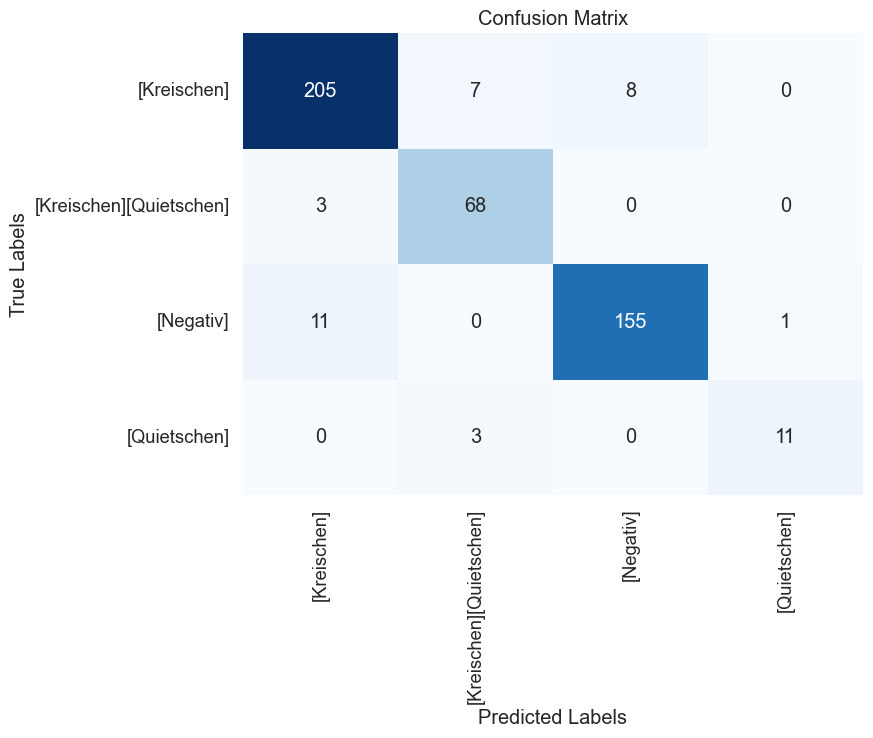

In [ ]:

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support,balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score



# Set the device for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#config.val_sound_length = 20

# Create a data loader for the test set
val_loader = DL.create_generators_finetune_val(val_df)  


model = torch.load(finetune_results_dir + '/checkpoint_best_loss.pth')
#model = torch.load('./finetune_results/FT_ADSMI_120_epochs_2023-11-11-15/checkpoint.pth')
# Transfer the model to the testing device
model.to(device)

# Define a criterion for evaluation 
criterion = nn.CrossEntropyLoss()

# Initialize variables for evaluation metrics (e.g., accuracy)
correct_predictions = 0
total_samples = 0

# Define the label dictionary
true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# Set the model to evaluation mode 
model.eval()

# Initialize lists to store all true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Iterate through the test set
with torch.no_grad():
    for spectrograms, labels in val_loader:
        # Move data to the testing device
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        
        # Compute the predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels to the lists
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
accuracy = np.mean(all_true_labels == all_predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


#calculate balanced accuracy
balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
#kappa score
cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


print(f"\nEvaluation Results:")
#print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")
print(f"Kappa: {cohens_kappa * 100:.2f}%")

conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
def plot_confusion_matrix(conf_mat, class_labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    
    class_labels = [str(label) for label in class_labels]
    
    ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)

    return plt.gcf()  # Return the current figure

#create classification results text file
with open(f'{finetune_results_dir}/results_file_best_loss.txt', 'w') as log_file:
    log_file.write(f"########################################################\n")
    log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
    log_file.write(f"Time Mask: {config.time_mask_param}\n")
    log_file.write(f"Random State:{randomstate} \n")
    log_file.write(f"Spectro:\n")
    log_file.write(f"        n_fft={2048},\n")
    log_file.write(f"        hop_length = {512},\n")
    log_file.write(f"        n_mels={128},  \n")
    log_file.write(f"        win_length = {2048},\n")
    log_file.write(f"Epochs: {num_epochs}\n")
    log_file.write(f"Batch size: {batch_size}\n")
    log_file.write(f"Optimizer: Adam\n")
    log_file.write(f"Learning rate: {learning_rate}\n")
    log_file.write(f"Weight decay: {weight_decay}\n")
    log_file.write(f"Scheduler: ReduceLROnPlateau\n")
    log_file.write(f"Model: ModifiedResnet50_Classifier \n")
    log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
    log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
    log_file.write(f"\nEvaluation Results:\n")
    log_file.write(f"Precision: {precision * 100:.2f}%\n")
    log_file.write(f"Recall: {recall * 100:.2f}%\n")
    log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
    log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Confusion Matrix:\n")
    log_file.write(f"{conf_mat}\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

#save this plot_confusion_matrix(conf_mat, true_labels_dic.values()) as a png file
plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
plot.savefig(f'{finetune_results_dir}/confusion_matrix_best_loss.png')









tensor([[[[33.3628, 38.8282, 44.3980,  ..., 26.9515, 24.7679, 24.5997],
          [37.6380, 43.5800, 47.8155,  ..., 22.9519, 20.0620, 15.5026],
          [39.1815, 43.2633, 43.1770,  ..., 22.4160, 23.8053, 19.5930],
          ...,
          [13.2262, 13.9038, 14.5840,  ...,  6.7016,  6.7412,  7.7779],
          [10.0246, 12.3764, 13.1446,  ...,  8.3356,  8.5048,  8.1607],
          [ 7.7716,  9.9761, 10.8741,  ...,  7.3372,  6.3651,  4.9631]],

         [[33.3628, 38.8282, 44.3980,  ..., 26.9515, 24.7679, 24.5997],
          [37.6380, 43.5800, 47.8155,  ..., 22.9519, 20.0620, 15.5026],
          [39.1815, 43.2633, 43.1770,  ..., 22.4160, 23.8053, 19.5930],
          ...,
          [13.2262, 13.9038, 14.5840,  ...,  6.7016,  6.7412,  7.7779],
          [10.0246, 12.3764, 13.1446,  ...,  8.3356,  8.5048,  8.1607],
          [ 7.7716,  9.9761, 10.8741,  ...,  7.3372,  6.3651,  4.9631]],

         [[33.3628, 38.8282, 44.3980,  ..., 26.9515, 24.7679, 24.5997],
          [37.6380, 43.5800, 4

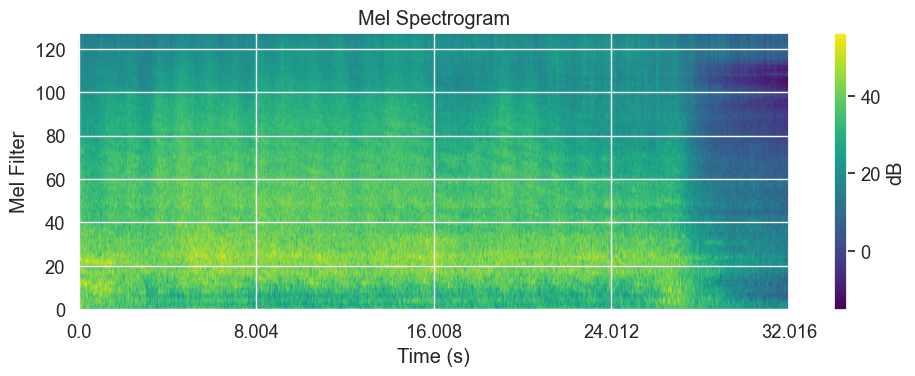

In [ ]:
#print first batch from val_loader
iterator = iter(val_loader)
batch = next(iterator)
spectrograms, labels = batch


print(spectrograms)
#plot spectrograms
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
def plot_mel_spectrogram(melspe_db, sample_rate, hop_length):
    plt.figure(figsize=(10, 4))

    # Assuming melspe_db is a 4D tensor and we only want to plot the first channel of the first sample
    melspe_db_np = melspe_db[0, 0].cpu().detach().numpy()  # Selecting the first channel

    plt.imshow(melspe_db_np, cmap='viridis', origin='lower', aspect='auto')
    plt.ylabel('Mel Filter')
    plt.xlabel('Time (s)')
    plt.colorbar(label='dB')
    plt.title('Mel Spectrogram')

    num_time_bins = melspe_db_np.shape[1]
    plt.xticks(np.linspace(0, num_time_bins, 5), np.linspace(0, num_time_bins * hop_length / sample_rate, 5))

    plt.tight_layout()
    plt.show()

#plot spectrograms

plot_mel_spectrogram(spectrograms, 32000, 512)